# Rozwiązanie Lab 5

In [1]:
import numpy as np
from PIL import Image
from _collections import deque
from termcolor import colored
from time import perf_counter

### Zad 1

### Wyszukiwanie pojedynczego wzorca w tekście( KMP )

Jest potrzebny jako ostatni krok w algorytmie wyszukiwania 2D, używam KMP zamiast automatu, gdyż alfabet w tym wyszukiwaniu stanowią możliwe stany automatu wyszukującego wiele wzorców, a więc może być ich dużo

In [2]:
def build_kmp_table(pattern):
    m = len(pattern)
    pi = [0 for _ in range(m)]
    k = 0
    for i in range(1, m):
        while k > 0 and pattern[i] != pattern[k]:
            k = pi[k-1]
        if pattern[i] == pattern[k]:
            k += 1
        pi[i] = k
    return pi

def kmp(pattern, text):
    m = len(pattern)
    pi = build_kmp_table(pattern)
    ans = []
    i = 0
    j = 0
    while j < len(text):
        while i > 0 and pattern[i] != text[j]:
            i = pi[i - 1]
        if pattern[i] == text[j]:
            i += 1
        if i == m:
            ans.append(j)
            i = pi[-1]
        j += 1

    return ans

### Wyszukiwanie wielu wzorców

Wartości funkcji przejścia przechowywane są w drzewie trie

In [3]:

# Węzeł w drzewie Trie
class Node:
    def __init__(self, node_id):
        self.id = node_id
        self.edges = {}
        self.prev = None
        self.terminal = False


def build_prefix_tree(patterns):
    root = Node(0)
    alphabet = set()
    id_count = 1
    terminals = []
    for pattern in patterns:
        cur = root
        for x in pattern:
            alphabet.add(x)
            if x not in cur.edges:
                new_node = Node(id_count)
                id_count += 1
                cur.edges[x] = new_node
            cur = cur.edges[x]

        cur.terminal = True
        terminals.append(cur.id)

    return root, terminals, list(alphabet)



def build_automaton(patterns):
    root, terminals, alphabet = build_prefix_tree(patterns)

    root.prev = root

    d = deque()
    for child in root.edges.values():
        child.prev = root
        d.append(child)

    for x in alphabet:
        if x not in root.edges:
            root.edges[x] = root

    while d:
        node = d.popleft()
        for x, child in node.edges.items():
            child.prev = node.prev.edges[x]
            d.append(child)

        for x in alphabet:
            if x not in node.edges:
                node.edges[x] = node.prev.edges[x]

    return root, terminals


def search_single_line(line, root):
    states = np.zeros(len(line))
    found = []
    cur = root
    for i, x in enumerate(line):
        if x not in cur.edges: # alfabet jest tworzony na podstawie znaków występujących we wzorcach, jeśli pojawia się litera, której nie ma
            cur = root         # to wiadomo, że należy wrócić do stanu 0
        else:
            cur = cur.edges[x]
        states[i] = cur.id
        if cur.terminal:
            found.append(i)

    return states, found


def two_dim_search(patterns, text):
    no_duplicates = list(set(patterns)) # żeby nie dodać kilkukrotnie tego samego słowa do drzewa trie
    root, terminals = build_automaton(no_duplicates)

    terminals_map = dict(zip(no_duplicates, terminals))
    id_pattern = np.array([terminals_map[l] for l in patterns]) # tworzenie patternu z symboli terminalnych oznaczających końce kolejnych wzorców

    state_array = np.zeros((len(text), len(text[0])))
    for i, line in enumerate(text):   # prechodzę oddzielnie po każdej linii i zaznaczam w którym stanie automatu znajdowaliśmy się w danej miejscu w stringu
        states, _ = search_single_line(line, root)
        state_array[i] = states

    found = []
    for i, line in enumerate(state_array.T):
        new_found = kmp(id_pattern, line)
        for ind in new_found:
            found.append((ind, i))
    return found



### Zad 2

In [4]:
with open("haystack.txt", "r") as f:
    haystack_text = f.readlines()

char_count1 = sum([len(l) for l in haystack_text])
width = max(len(l) for l in haystack_text) - 1
haystack_text = list(map(lambda l: str.ljust(l, width), filter(len, map(lambda l: l[:-1], haystack_text))))
char_count2 = sum([len(l) for l in haystack_text])
print(f"Ilośc znaków przed dodaniem spacji {char_count1} i po dodanie spacji {char_count2}")
# usunięcie symbolu końca linii, pustych linii, a także wyrównanie wszystkich linii poprzez uzpełnienie linii spacjami
# znacząco ułatwia to implementację a ilość znaków bardzo się nie zwiększa

Ilośc znaków przed dodaniem spacji 6266 i po dodanie spacji 8715


In [5]:

# wyświetlenie tekstu z szukanami fragmentu pokolorowanymi na czerwono
def highlight(to_color, text):
    for i, line in enumerate(text):
        for j, x in enumerate(line):
            if (i, j) in to_color:
                print(colored(x, 'red'), end="")
            else:
                print(x, end="")
        print()


def zad2(text):
    patterns = [(chr(i) + chr(i)) for i in range(97, 123)]
    patterns += list(map(str.upper, patterns))
    lines = []
    for i in range(width):
        lines.append("".join([text[j][i] for j in range(len(text))]))

    root, _ = build_automaton(patterns)

    to_color = set()
    count_found = 0
    for i, line in enumerate(lines):
        states, found = search_single_line(line, root)
        count_found += len(found)
        if found:
            for ind in found:
                to_color.add((ind, i))
                to_color.add((ind - 1, i))

    print(f"Licznik wystąpień szukanego wzorca: {count_found}\n\n")
    highlight(to_color, text)

In [6]:
zad2(haystack_text)

Licznik wystąpień szukanego wzorca: 236


One of the simplest and n a t u r a l types of information representation is by means                    
of written texts. This type of d a t a is characterized by t h e fact t h a t it can                     
be written down as a long sequence of characters. Such linear a sequence                                 
is called a text. T h e texts are central in "word processing" systems, which                            
provide facilities for t h e manipulation of texts. Such systems usually process                         
objects t h a t are quite large. For example, this book probably contains more                           
t h a n a million characters. Text algorithms occur in many areas of science and                         
information processing. Many text editors and programming languages have                                 
facilities for processing texts. In biology, text algorithms arise in the study                          
of m

### Zad 3

In [6]:
def zad3(patterns, text):
    m = len(patterns)
    n = len(patterns[0])
    found = two_dim_search(patterns, text)
    to_color = set()
    for a, b in found:
        for i in range(a, a - m, -1):
            for j in range(b, b - n, -1):
                to_color.add((i, j))

    print(f"Licznik wystąpień szukanego wzorca: {len(found)}\n\n")
    highlight(to_color, text)


In [8]:
zad3(['th', 'th'], haystack_text)

Licznik wystąpień szukanego wzorca: 0


One of the simplest and n a t u r a l types of information representation is by means                    
of written texts. This type of d a t a is characterized by t h e fact t h a t it can                     
be written down as a long sequence of characters. Such linear a sequence                                 
is called a text. T h e texts are central in "word processing" systems, which                            
provide facilities for t h e manipulation of texts. Such systems usually process                         
objects t h a t are quite large. For example, this book probably contains more                           
t h a n a million characters. Text algorithms occur in many areas of science and                         
information processing. Many text editors and programming languages have                                 
facilities for processing texts. In biology, text algorithms arise in the study                          
of mol

In [9]:
zad3(['t h', 't h'], haystack_text)

Licznik wystąpień szukanego wzorca: 1


One of the simplest and n a t u r a l types of information representation is by means                    
of written texts. This type of d a t a is characterized by t h e fact t h a t it can                     
be written down as a long sequence of characters. Such linear a sequence                                 
is called a text. T h e texts are central in "word processing" systems, which                            
provide facilities for t h e manipulation of texts. Such systems usually process                         
objects t h a t are quite large. For example, this book probably contains more                           
t h a n a million characters. Text algorithms occur in many areas of science and                         
information processing. Many text editors and programming languages have                                 
facilities for processing texts. In biology, text algorithms arise in the study                          
of mol

### Zad 4

In [7]:
img = Image.open('haystack.png')
img_array = np.array(img)[:, :, 0]

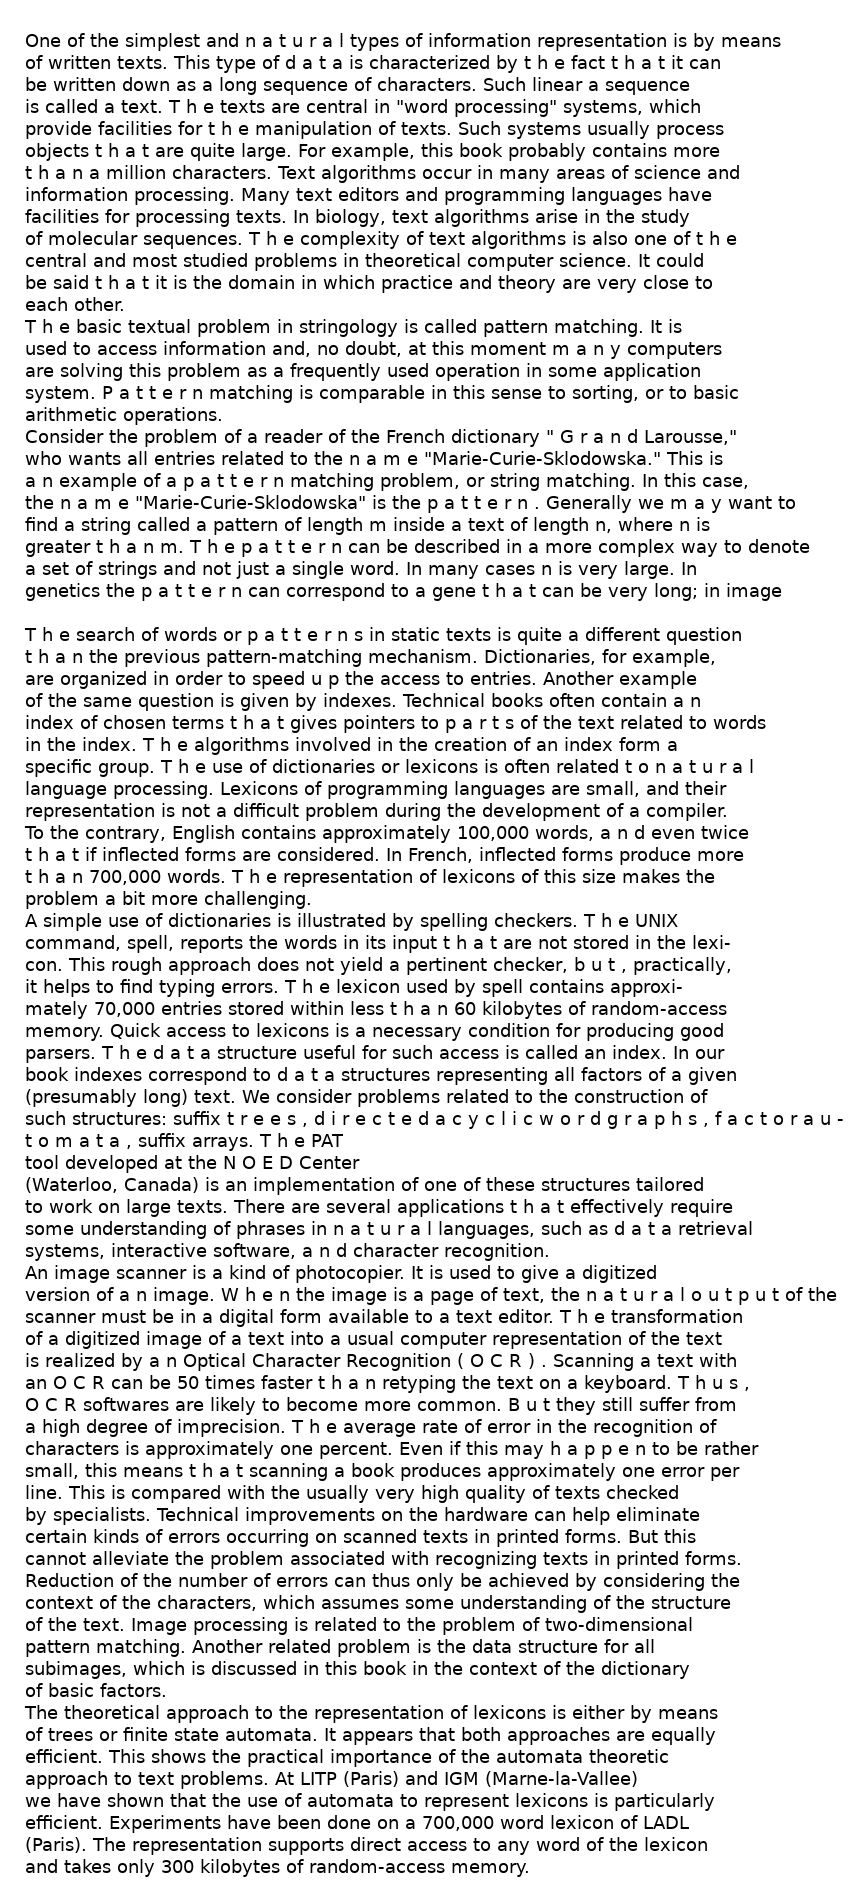

In [41]:
display(Image.fromarray(img_array))

In [12]:

# Wyświetla tekst z szukanym wzorcem zaznaczonym na czerwono
def display_found_pattern(found, m, n):
    open_img = Image.open('haystack.png').convert('RGB')
    im = np.array(open_img)
    red = (255, 0, 0)
    for a, b in found:
        for i in range(a, a - m, -1):
            im[i, b] = red
            im[i, b - n + 1] = red

        for i in range(b, b - n, -1):
            im[a, i] = red
            im[a - m + 1, i] = red

    display(Image.fromarray(im))

# obraz wczytywany jest początkowo do numpy arrayów, które zamieniam na listę stringów, gdyż to ułatwia haszowanie
def ndarray_to_string(array):
    patterns = []
    for row in array:
        patterns.append("")
        for ind in row:
            patterns[-1] += chr(ind)
    return patterns

def find_image_pattern(image, pattern_img):
    letter = Image.open(pattern_img)
    pattern = np.array(letter)
    patterns = ndarray_to_string(pattern)
    text = ndarray_to_string(image)
    found = two_dim_search(patterns, text)
    print(f"Licznik wystąpień szukanego wzorca: {len(found)}\n\n")
    display_found_pattern(found, len(patterns), len(patterns[0]))

Licznik wystąpień szukanego wzorca: 335




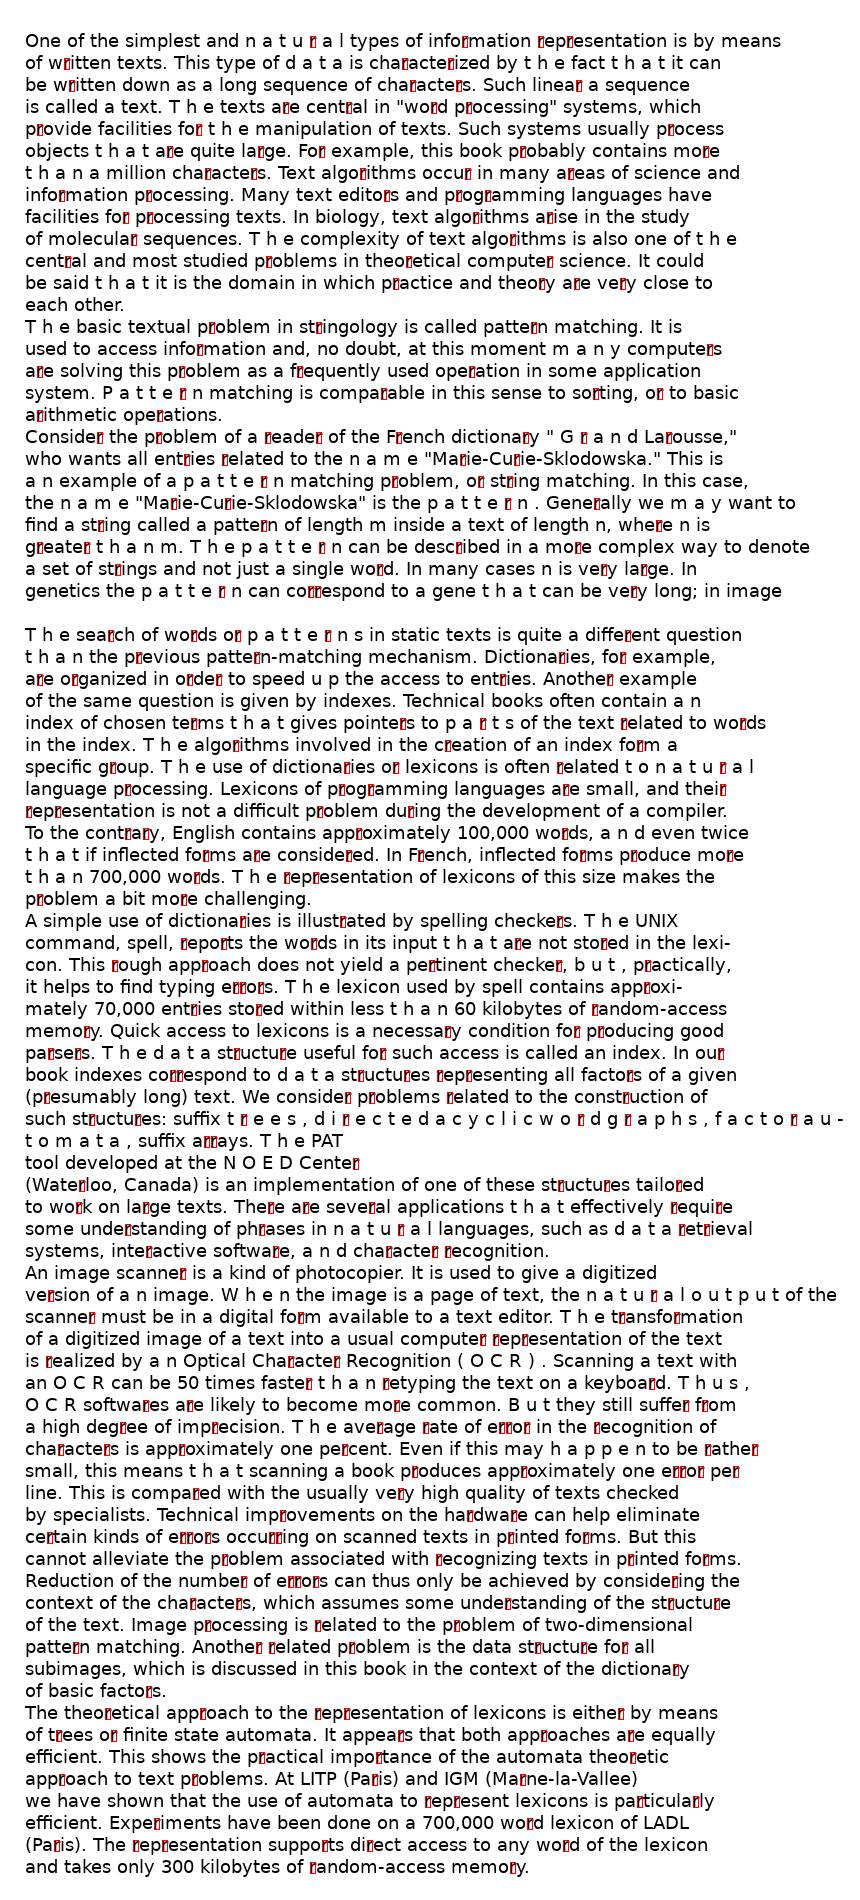

In [12]:
# litera r
find_image_pattern(img_array, "r.png")

Licznik wystąpień szukanego wzorca: 397




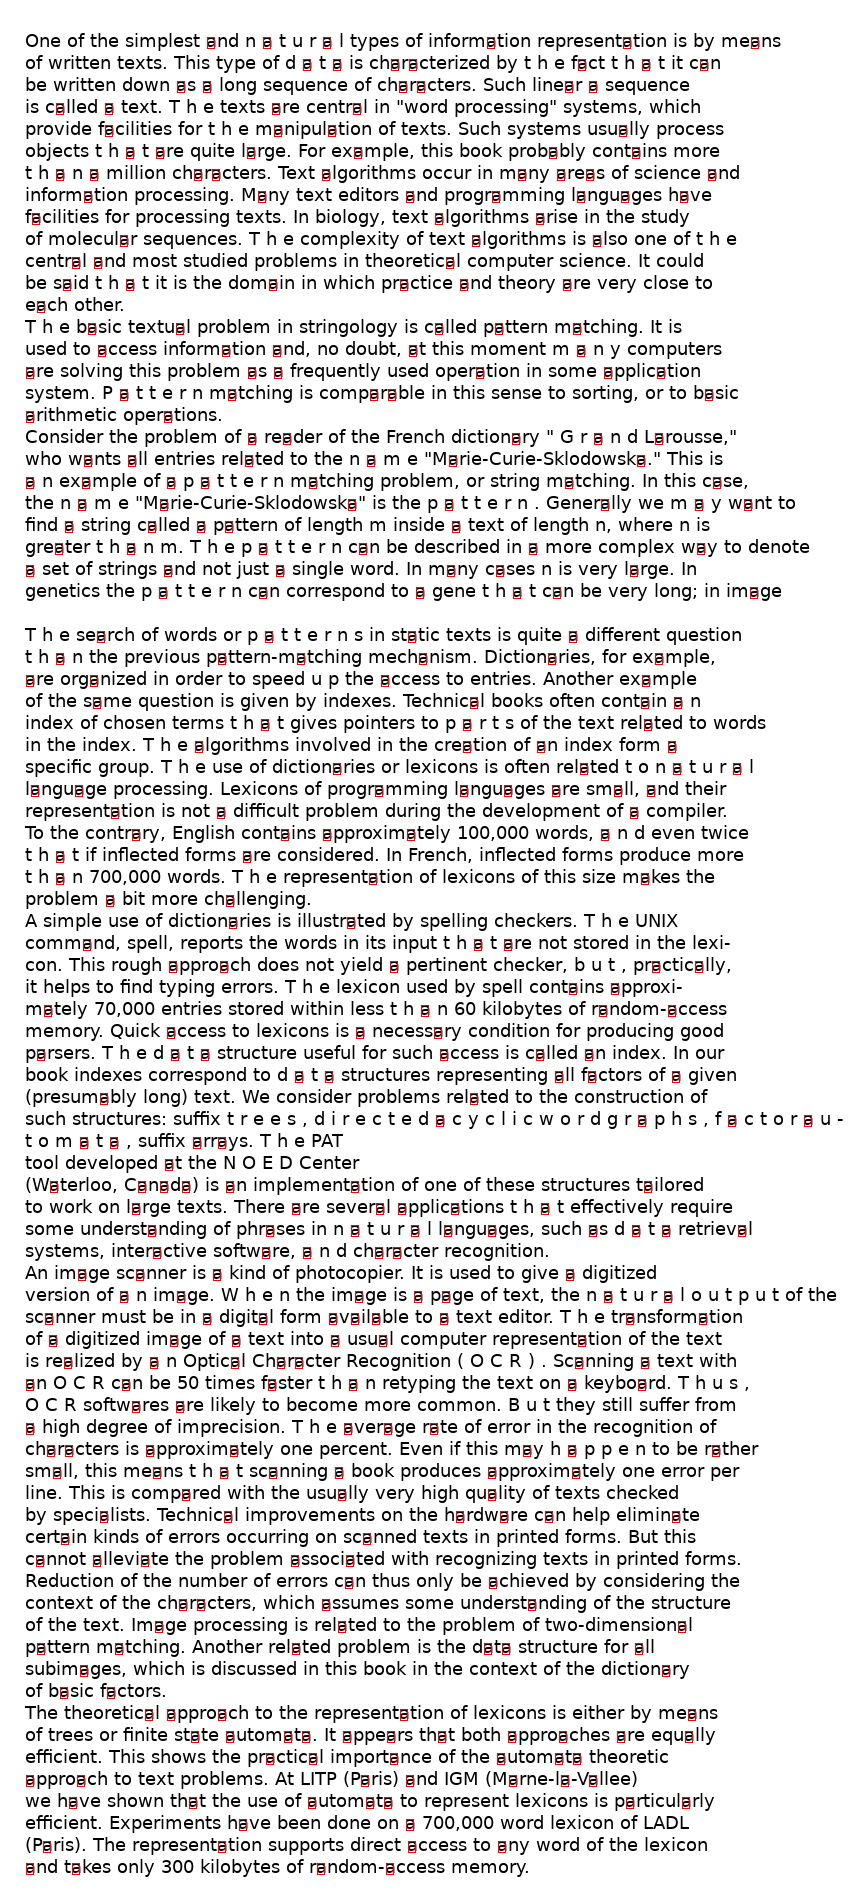

In [46]:
# litera a
find_image_pattern(img_array, "a.png")

Licznik wystąpień szukanego wzorca: 91




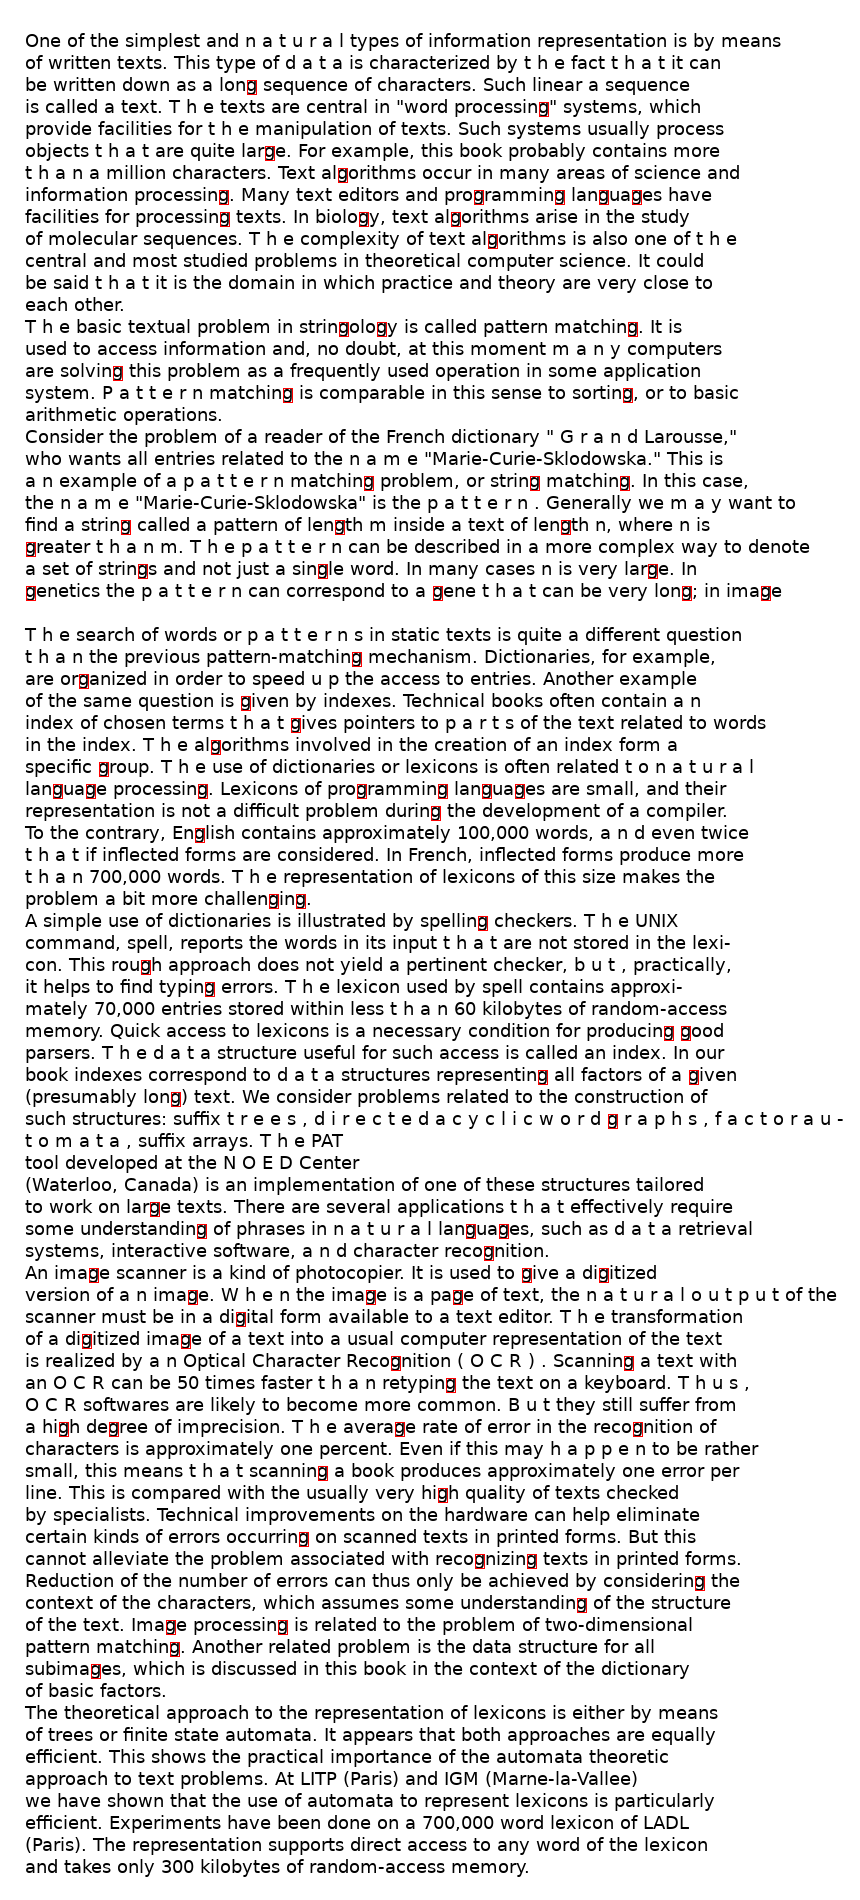

In [47]:
# litera g
find_image_pattern(img_array, "g.png")

Licznik wystąpień szukanego wzorca: 131




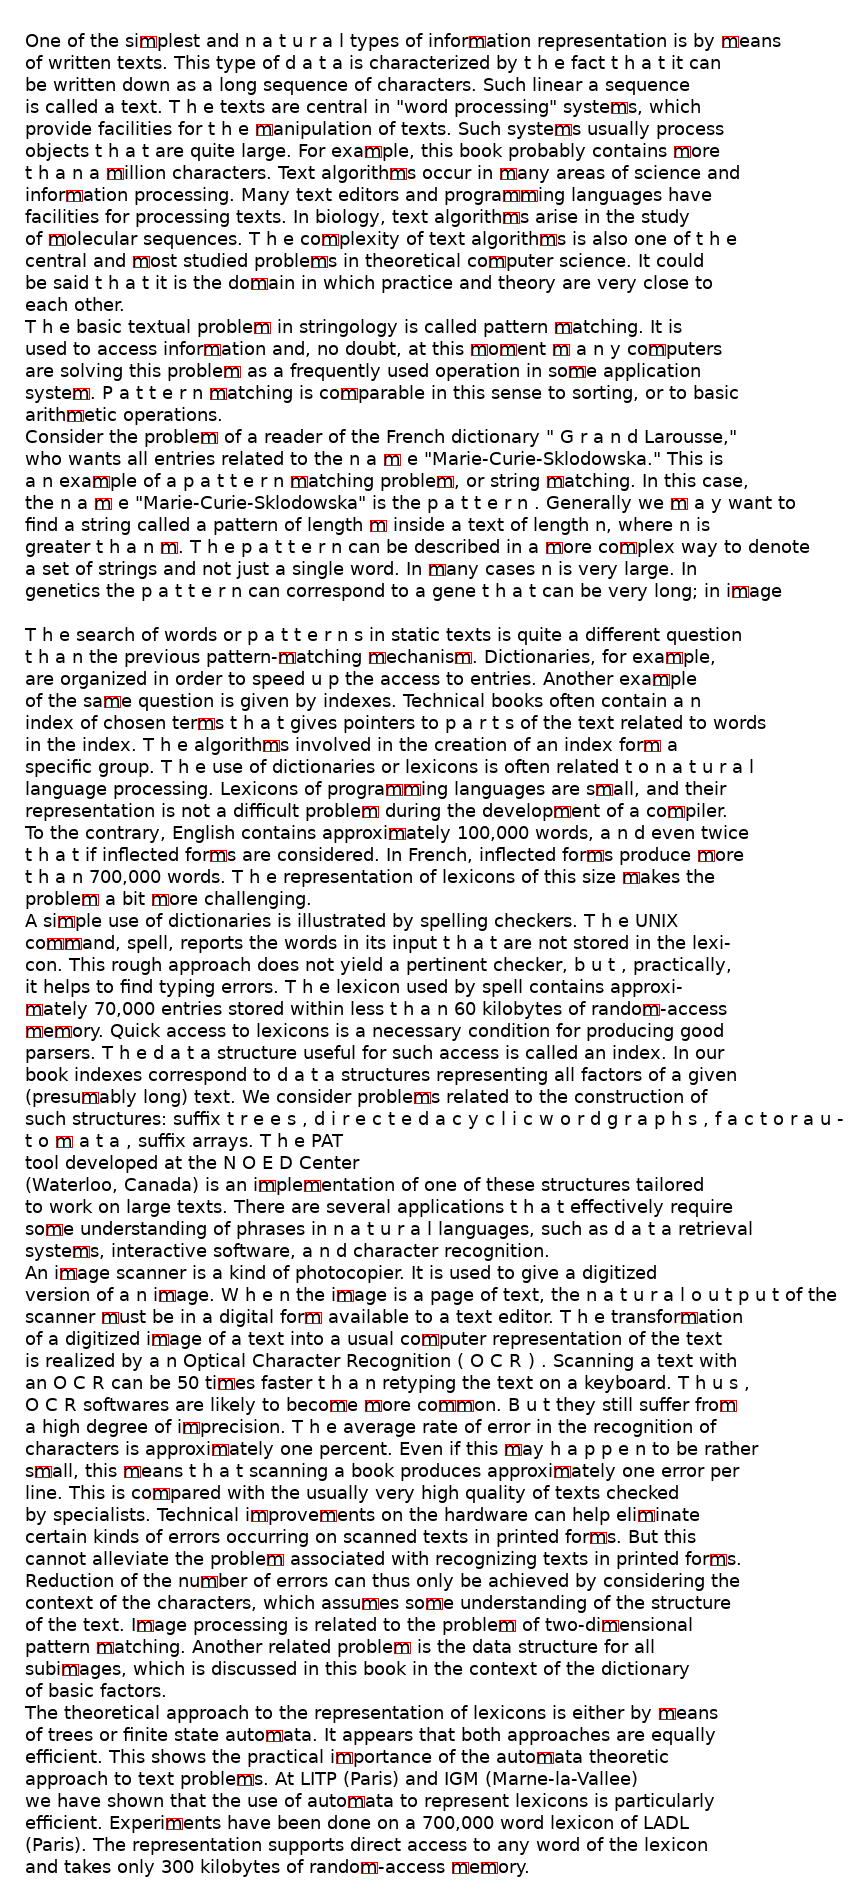

In [48]:
# litera m
find_image_pattern(img_array, "m.png")

### Zad 5

Licznik wystąpień szukanego wzorca: 5




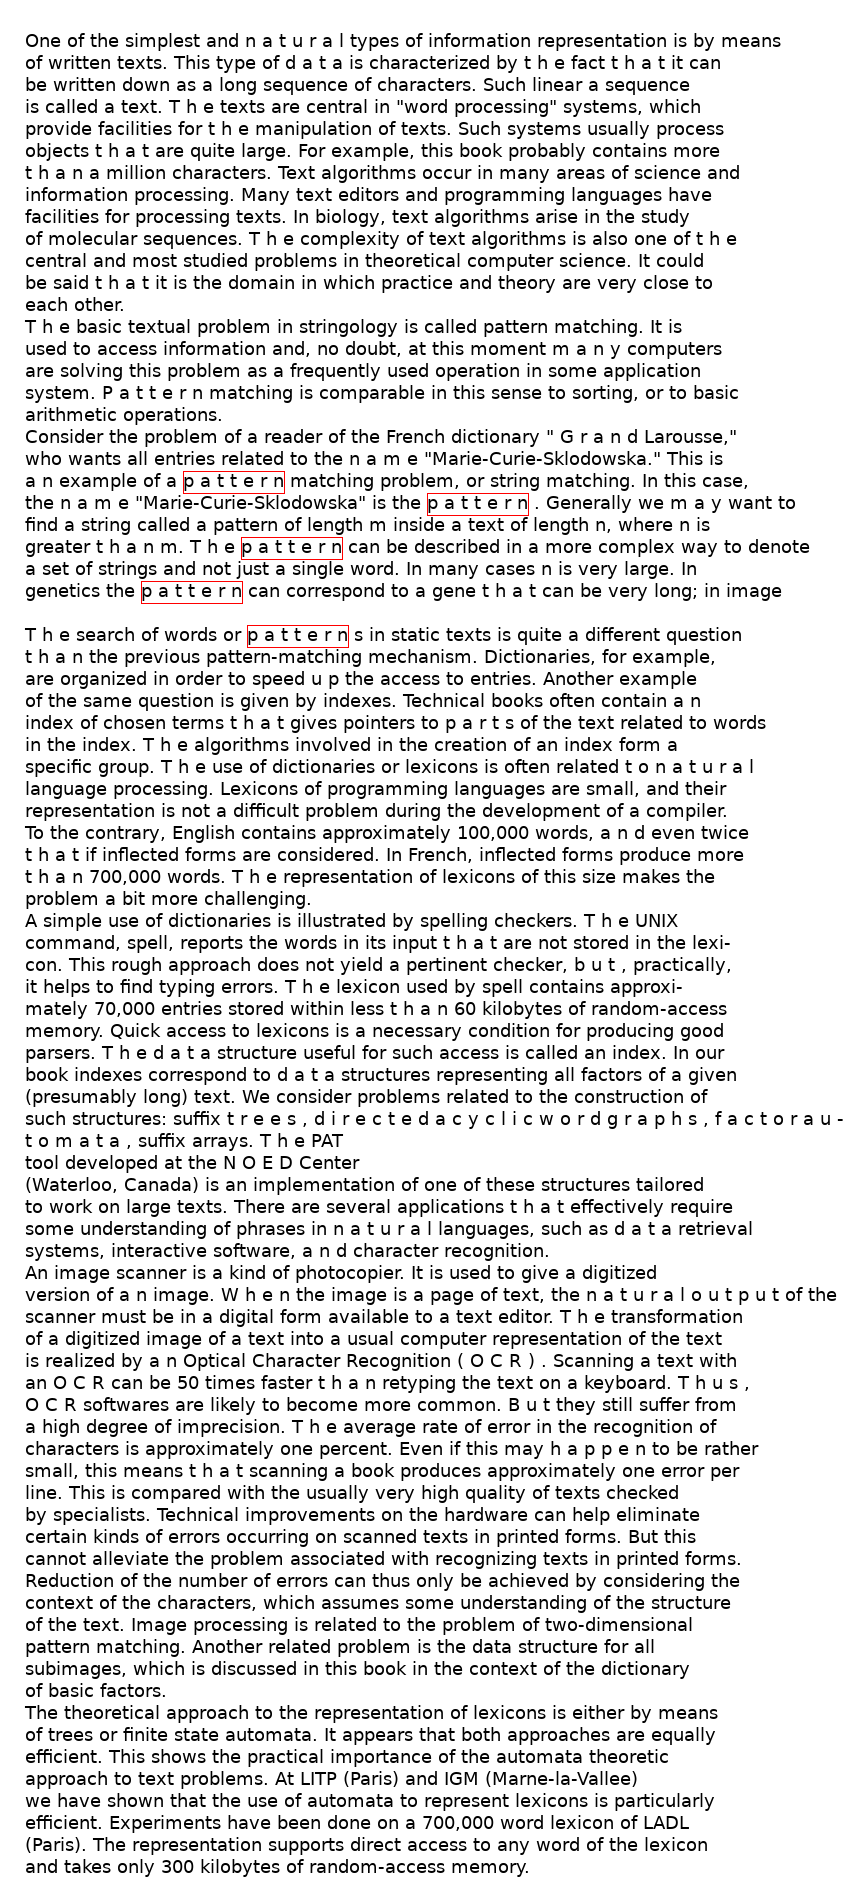

In [49]:
find_image_pattern(img_array, "pattern.png")

### Zad 6

Porównanie czasów budowy automatu i wyszukiwanie wzorca w zależności od wielkości wzorca.
Do testów używam wzorców wyciętych z 'haystack.png'.

In [7]:
def compare_build_time():
    photos = ["a.png", "m.png", "pattern.png", "crop1.png", "crop2.png"]
    for photo in photos:
        letter = Image.open(photo)
        pattern = np.array(letter)
        patterns = ndarray_to_string(pattern)
        size = len(patterns) * len(patterns[0])
        print(f"Rozmiar wzorca {size}")
        t1 = perf_counter()
        root, terminals = build_automaton(patterns)
        print(f"Czas budowy automatu: {perf_counter() - t1}\n\n")
        display(letter)
        print("\n\n")

Rozmiar wzorca 96
Czas budowy automatu: 0.001389299999573268







Rozmiar wzorca 204
Czas budowy automatu: 0.001552000001538545







Rozmiar wzorca 2346
Czas budowy automatu: 0.04921440000180155







Rozmiar wzorca 42185
Czas budowy automatu: 3.589015699995798




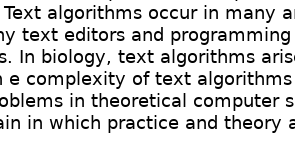




Rozmiar wzorca 304320
Czas budowy automatu: 11.532602700004645




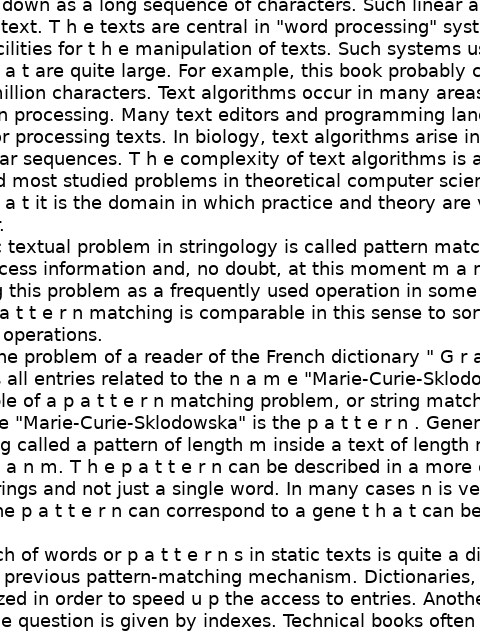

In [15]:
compare_build_time()

In [22]:
# Funkcja mierząca czas przeszukiwania uwzględnia zarówno czas budowy jak i samego szukania
photos = ["a.png", "m.png", "pattern.png", "crop1.png", "crop2.png"]

def compare_search_time(image):
    text = ndarray_to_string(image)
    for photo in photos:
        letter = Image.open(photo)
        pattern = np.array(letter)
        patterns = ndarray_to_string(pattern)
        print(f"Rozmiar wzorca {len(patterns) * len(patterns[0])}, Rozmiar przeszukiwanego tekstu {len(text) * len(text[0])}")
        t1 = perf_counter()
        found = two_dim_search(patterns, text)
        print(f"Czas przeszukiwania: {perf_counter() - t1}")
        print(f"Znaleziono {len(found)} wzorców")
        print("------------------------------------")

In [19]:
compare_search_time(img_array)

Rozmiar wzorca 96, Rozmiar przeszukiwanego tekstu 1634000
Czas przeszukiwania: 4.072998600000574
Znaleziono 397 wzorców
------------------------------------
Rozmiar wzorca 204, Rozmiar przeszukiwanego tekstu 1634000
Czas przeszukiwania: 2.3243373000004794
Znaleziono 131 wzorców
------------------------------------
Rozmiar wzorca 2346, Rozmiar przeszukiwanego tekstu 1634000
Czas przeszukiwania: 2.1580962000007275
Znaleziono 5 wzorców
------------------------------------
Rozmiar wzorca 42185, Rozmiar przeszukiwanego tekstu 1634000
Czas przeszukiwania: 3.168500199994014
Znaleziono 1 wzorców
------------------------------------
Rozmiar wzorca 304320, Rozmiar przeszukiwanego tekstu 1634000
Czas przeszukiwania: 12.384304700004577
Znaleziono 1 wzorców
------------------------------------


### Zad 7

Przy porównywaniu dwóch metod będę używał mniejszych wzorców, np. liter, należy uwzględnić sytuację w której szukany wzorzec znajduje się w miejscu podziału zdjęcia. Każdą część należy więc trochę powiększyć, aby taka sytuacja nie zaszła. Przy większych wzorcach byłoby to nieopłacalne. Dla każdego podziału na nowo tworzę automat, jednak ma to bardzo mały wpływ na czas, gdyż wzorce są małe


In [23]:

def distribute_image(text, n, l):
    m = len(text)
    p = m // n
    image_parts = []
    last = 0
    for i in range(n - 1):
        image_parts.append(text[last:last + p + l + 1])
        last += p

    image_parts.append(text[last:-1])
    return image_parts



def divide_and_search(photo, image, n):
    text = ndarray_to_string(image)
    letter = Image.open(photo)
    pattern = np.array(letter)
    patterns = ndarray_to_string(pattern)

    t = perf_counter()
    image_parts = distribute_image(text, n, len(patterns))
    count = 0
    for i in range(n):
        count += len(two_dim_search(patterns, image_parts[i]))
    print(f"Czas działania {perf_counter() - t}")
    print(f"Licznik wzorców {count}")
    print(f"Liczba poziomych podziałów {n}")
    print("------------------------------")


In [24]:
for t in [2, 4, 8]:
    for p in photos[:-1]:
        divide_and_search(p, img_array, t)

Czas działania 2.650409000001673
Licznik wzorców 397
Liczba poziomych podziałów 2
------------------------------
Czas działania 1.6615524000008008
Licznik wzorców 131
Liczba poziomych podziałów 2
------------------------------
Czas działania 1.7507741000008537
Licznik wzorców 5
Liczba poziomych podziałów 2
------------------------------
Czas działania 3.677650799996627
Licznik wzorców 1
Liczba poziomych podziałów 2
------------------------------
Czas działania 1.2669667999944068
Licznik wzorców 397
Liczba poziomych podziałów 4
------------------------------
Czas działania 1.7017113999972935
Licznik wzorców 135
Liczba poziomych podziałów 4
------------------------------
Czas działania 1.8602834999983315
Licznik wzorców 5
Liczba poziomych podziałów 4
------------------------------
Czas działania 8.732206399996358
Licznik wzorców 1
Liczba poziomych podziałów 4
------------------------------
Czas działania 1.2728266999984044
Licznik wzorców 401
Liczba poziomych podziałów 8
----------------

Wyniki zgadzają się z tymi otrzymanymi wcześniej. Czasy się jednak znacząco nie różnią, lecz widać, że taki algorytm można łatwo wykonać równoległe i wtedy wyniki na pewno byłyby lepsze